In [27]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
import seaborn as sns

In [2]:
with open("newsdatasetshuffle_4000.csv", 'r') as csvfile:
    print(f"Header:\n\n{csvfile.readline()}")
    print(f"Data point:\n\n{csvfile.readline()}")

Header:

,source,url,title,timestamp,label

Data point:

0,detik,https://finance.detik.com/berita-ekonomi-bisnis/d-5543655/stok-gula-aman-pabrik-makanan-siap-ngebut-lagi,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",23 Apr 2021 13:01 WIB,industri



In [3]:
NUM_WORDS = 10000
EMBEDDING_DIM = 32
MAXLEN = 40
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .85

In [4]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[5])
            sentence = row[3]
            sentences.append(sentence)

    return sentences, labels

In [5]:
sentences, labels = parse_data_from_file("newsdatasetshuffle_4000.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 4000 sentences in the dataset.

There are 4000 labels in the dataset.

The first 5 labels are ['industri', 'perang', 'properti', 'teknologi', 'perang']


In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
len(stopwords_ind)

758

In [7]:
def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [9]:
def text_preprocessing_process(text):
    text = remove_stop_words(text)
    text = stemming(text)
    return text

In [10]:
print(sentences)

['Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi', 'Secuplik Nestapa Ethiopia, Negara Miskin yang Terjebak Perang Saudara', 'Ssstt!! Ini Rahasia Tajir Jual-Beli Properti', 'Menteri Era SBY Yakin Nadiem Makarim Majukan Pendidikan RI', 'Dewan Kolonel Vs Dewan Kopral, Perang Dukungan buat Puan dan Ganjar Maju Pilpres 2024', 'Prinsipal Chery Mau Bangun Pusat Litbang di Indonesia', 'Ini Cara Pakai Teknologi Pengukur Celana Otomatis dari Kasual', 'Mantan Menkeu & Gubernur BI Bicara Soal Resesi, RI Bisa Kena?', 'Mentan: Hati-hati yang Makan Mi, Besok Harganya Naik 3 Kali Lipat', 'Ada Jurang antara Vokasi dan Industri, Pengusaha Mau Lakukan Ini', 'Anak-anak hingga Lansia di Lviv Ukraina Berlatih Gunakan Senjata', 'Jokowi\xa0Sebut Strategi Gas-Rem Saat Pandemi\xa0Sukses Pulihkan Industri', '5 Profesi yang Bisa Dilakukan di Rumah, Mahasiswa Pilih Mana?', 'Kata Sri Mulyani, Minyak Jadi Mahal gara-gara Jadi Alat Perang', 'Survei BI: Harga Properti Melambat di Kuartal I 2021', 'Ada Pemerintah dan 

In [11]:
sentences_nostopword = []
for i in sentences:
    sentences_nostopword.append(text_preprocessing_process(i))
sentences = sentences_nostopword
print(sentences)

['stok gula aman pabrik makan siap ngebut lagi', 'cuplik nestapa ethiopia negara miskin jebak perang saudara', 'ssstt ini rahasia tajir jual-beli properti', 'menteri era sby yakin nadiem makarim maju didik ri', 'dewan kolonel vs dewan kopral perang dukung puan ganjar maju pilpres 2024', 'prinsipal chery mau bangun pusat litbang indonesia', 'ini cara pakai teknologi ukur celana otomatis kasual', 'mantan menkeu gubernur bi bicara soal resesi ri bisa kena', 'tan hati makan mi besok harga naik 3 kali lipat', 'ada jurang vokasi industri usaha mau laku ini', 'anak lansia lviv ukraina latih guna senjata', 'jokowi sebut strategi gas-rem saat pandemi sukses pulih industri', '5 profesi bisa laku rumah mahasiswa pilih mana', 'kata sri mulyani minyak jadi mahal gara-gara jadi alat perang', 'survei bi harga properti lambat kuartal i 2021', 'ada perintah atur dalam kencang alih fungsi lahan', 'industri film indonesia bangkit pascapandemi fajar nugros bilang begini', 'ekonomi ri ramal kalah china 202

In [12]:
def train_val_split(sentences, labels, training_split):
    
    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(sentences, labels, 
                                                                                              test_size=1-training_split,
                                                                                              random_state=10)
    validation_sentences, test_sentences, validation_labels, test_labels = train_test_split(validation_sentences,
                                                                                            validation_labels,
                                                                                            test_size=0.5,
                                                                                            random_state=10)
    
    return train_sentences, validation_sentences, test_sentences, train_labels, validation_labels, test_labels

In [13]:
train_sentences, val_sentences, test_sentences, train_labels, val_labels, test_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.\n")
print(f"There are {len(test_sentences)} sentences for test.\n")
print(f"There are {len(test_labels)} labels for test.")

There are 3399 sentences for training.

There are 3399 labels for training.

There are 300 sentences for validation.

There are 300 labels for validation.

There are 301 sentences for test.

There are 301 labels for test.


In [14]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [15]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 4993 words

<OOV> token included in vocabulary


In [16]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [17]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3399, 40)

Padded validation sequences have shape: (300, 40)


In [18]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    substracted_label_seq=[]
    for i in label_seq:
        for j in i:
            substracted_label_seq.append([j-1])
    
    label_seq_np = np.array(substracted_label_seq)
    
    ### END CODE HERE
    
    return label_seq_np

In [19]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)
test_label_seq = tokenize_labels(labels, test_labels)

print(f"First 10 labels of the training set should look like this:\n{train_label_seq[:10]}\n")
print(f"First 10 labels of the validation set should look like this:\n{val_label_seq[:10]}\n")
print(f"First 10 labels of the test set should look like this:\n{test_label_seq[:10]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")
print(f"Tokenized labels of the test set have shape: {test_label_seq.shape}\n")

First 10 labels of the training set should look like this:
[[4]
 [3]
 [2]
 [2]
 [1]
 [3]
 [4]
 [1]
 [0]
 [1]]

First 10 labels of the validation set should look like this:
[[1]
 [4]
 [3]
 [2]
 [0]
 [0]
 [4]
 [1]
 [3]
 [3]]

First 10 labels of the test set should look like this:
[[1]
 [2]
 [2]
 [1]
 [1]
 [2]
 [0]
 [4]
 [4]
 [0]]

Tokenized labels of the training set have shape: (3399, 1)

Tokenized labels of the validation set have shape: (300, 1)

Tokenized labels of the test set have shape: (301, 1)



In [20]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(6650, 64, input_length=maxlen),
        tf.keras.layers.Conv1D(128,10,activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [21]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=5, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/5
107/107 [==============================] - 9s 33ms/step - loss: 1.6093 - accuracy: 0.1992 - val_loss: 1.6080 - val_accuracy: 0.2133
Epoch 2/5
107/107 [==============================] - 2s 20ms/step - loss: 1.6058 - accuracy: 0.2424 - val_loss: 1.6018 - val_accuracy: 0.2567
Epoch 3/5
107/107 [==============================] - 2s 20ms/step - loss: 1.5539 - accuracy: 0.3948 - val_loss: 1.4137 - val_accuracy: 0.4567
Epoch 4/5
107/107 [==============================] - 2s 19ms/step - loss: 1.1115 - accuracy: 0.5681 - val_loss: 1.0173 - val_accuracy: 0.6067
Epoch 5/5
107/107 [==============================] - 2s 20ms/step - loss: 0.7915 - accuracy: 0.7211 - val_loss: 0.9456 - val_accuracy: 0.6367


In [22]:
predict_y = model.predict(test_padded_seq)
print(predict_y)

10/10 [==============================] - 1s 10ms/step
[[0.02142179 0.71510607 0.04589687 0.16169816 0.05587713]
 [0.12533057 0.09012143 0.17303574 0.5730483  0.03846391]
 [0.04712662 0.06739677 0.6567712  0.22130558 0.00739983]
 ...
 [0.00525051 0.89093685 0.00738995 0.03686567 0.05955709]
 [0.2651778  0.04511641 0.00274931 0.17659731 0.51035917]
 [0.17112821 0.09285412 0.06822811 0.58448565 0.08330389]]


In [23]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [24]:
# print((test_label_seq))
y_predict = []
for i in predict_y:
    y_predict.append(tf.argmax(i))
y = classification_report(test_label_seq,y_predict, target_names=le.classes_)
# print(y_predict)



# test_label_seq

In [25]:
print(y)

              precision    recall  f1-score   support

    industri       0.72      0.42      0.53        50
pemerintahan       0.81      0.83      0.82        65
      perang       0.77      0.62      0.69        58
    properti       0.44      0.64      0.53        56
   teknologi       0.70      0.75      0.72        72

    accuracy                           0.67       301
   macro avg       0.69      0.65      0.66       301
weighted avg       0.69      0.67      0.67       301



[Text(0, 0.5, 'industri'),
 Text(0, 1.5, 'pemerintahan'),
 Text(0, 2.5, 'perang'),
 Text(0, 3.5, 'properti'),
 Text(0, 4.5, 'teknologi')]

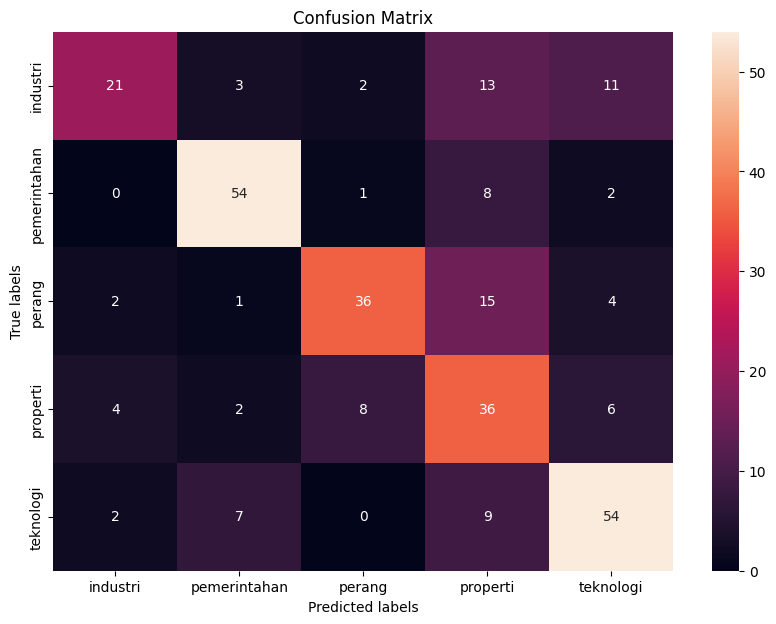

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix(test_label_seq,y_predict),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

In [29]:
lst_predict = ['Pemerintah Menetapkan Batas Tarif Tertinggi Rapid Test Antigen Covid-19','Pemerintah Izinkan Warga di Bawah 45 Tahun Kembali Beraktivitas ','Pengamat Minta Pemerintah Tetap Buka Impor Produk dari Cina','Tuntut Upah Naik 13 Persen, Demo Buruh Nyalakan Smoke Bomb di Patung Kuda','BPS Beberkan Kondisi Ekspor RI ke Cina Selama Pandemi dan Perang Rusia-Ukraina','Perang Ukraina, Tentara Belarus Bergabung dengan Rusia','Jika Ukraina Bergabung NATO, Pejabat Rusia: Perang Dunia III Akan Terjadi','Ini Bahaya Radiasi Nuklir bagi Manusia Jika Perang Nuklir Dunia Terjadi','Alasan Gibran Wajibkan Industri Kecil dan Menengah di Solo Go Digital','Qualcomm, Razer dan Verizon Perkenalkan Perangkat Game 5G dengan Snapdragon G3x','Smarthome Samsung - Google: Apapun Perangkatnya, Aplikasinya Tetap','Energy Watch Beberkan Kendala Listrik Tenaga Surya: Belum Ada Teknologi Baterai Murah','Mahasiswa Universitas Teknologi Sumbawa Bikin Mobil Listrik, Namanya NgebUTS','Mandiri Festival Properti Indonesia 2022 Hadirkan 37 Projek dari 17 Pengembang','Pemerintah Maksimalkan Potensi Industri Kopi Nasional','Industri Haus Listrik Terancam Gulung Tikar, Kadin: Investor Pelan-pelan Pindah ke Luar Negeri','Manfaat Garam dalam Industri dan Medis Modern','CEO Avoskin Cerita Awal Bangun Usaha, Kumpulkan Tabungan Sejak Jadi Agen Properti','Festival Properti Indonesia Digelar, Ada Promo KPR Mandiri Berbunga 2,4 Persen','Deal, Ciputra Group Berkomitmen Bangun Properti 300 Hektar di IKN ']

In [30]:
print(len(lst_predict))

20


In [31]:
sentences_nostopword = []
for i in lst_predict:
    sentences_nostopword.append(text_preprocessing_process(i))
lst_predict = sentences_nostopword
print(lst_predict)

['perintah tetap batas tarif tinggi rapid test antigen covid-19', 'perintah izin warga bawah 45 tahun kembali aktivitas', 'amat minta perintah tetap buka impor produk cina', 'tuntut upah naik 13 persen demo buruh nyala smoke bomb patung kuda', 'bps kan kondisi ekspor ri cina lama pandemi perang rusia-ukraina', 'perang ukraina tentara belarus gabung rusia', 'jika ukraina gabung nato jabat rusia perang dunia iii akan jadi', 'ini bahaya radiasi nuklir manusia jika perang nuklir dunia jadi', 'alas gibran wajib industri kecil tengah solo go digital', 'qualcomm razer verizon kenal perangkat game 5g snapdragon g3x', 'smarthome samsung - google apa perangkat aplikasi tetap', 'energy watch kan kendala listrik tenaga surya belum ada teknologi baterai murah', 'mahasiswa universitas teknologi sumbawa bikin mobil listrik nama ngebuts', 'mandiri festival properti indonesia 2022 hadir 37 projek 17 kembang', 'perintah maksimal potensi industri kopi nasional', 'industri haus listrik ancam gulung tikar 

In [32]:
lst_predict_padded_seq = seq_and_pad(lst_predict, tokenizer, PADDING, MAXLEN)
print(f"Padded test_predict sequences have shape: {lst_predict_padded_seq.shape}")

Padded test_predict sequences have shape: (20, 40)


In [33]:
print(lst_predict_padded_seq)

[[   4  277  532  909  135    1 3460 3558  228  280    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   4  784   51  420 4632   47  185 1874    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 819   36    4  277   50  416  173    1    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 609 1268   29 1239   72 1032  562 4750    1    1 2654 2655    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2325  527  810  243    9    1  342   93   10    6    8    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [34]:
resultt = model.predict(lst_predict_padded_seq)
print(resultt)

1/1 [==============================] - 1s 552ms/step
[[1.78628832e-01 5.10370694e-02 1.50534918e-03 1.12018928e-01
  6.56809807e-01]
 [8.88137892e-02 2.08393618e-01 2.81178788e-03 1.46679044e-01
  5.53301752e-01]
 [1.38129666e-01 6.39692601e-03 1.93406187e-04 1.65359173e-02
  8.38744104e-01]
 [9.33002159e-02 1.73535794e-02 3.33026837e-04 1.99134741e-02
  8.69099736e-01]
 [5.20569645e-03 8.81559491e-01 5.44657139e-03 3.00114471e-02
  7.77767822e-02]
 [4.11662459e-03 9.11777079e-01 9.70045291e-03 4.31200154e-02
  3.12858410e-02]
 [3.29522160e-03 9.16954041e-01 6.39055250e-03 2.83075869e-02
  4.50526886e-02]
 [4.19723289e-03 9.03170347e-01 6.39071455e-03 3.13666835e-02
  5.48750013e-02]
 [5.99925876e-01 8.19193199e-03 1.03232108e-01 2.37900198e-01
  5.07499427e-02]
 [1.12735108e-01 2.10538372e-01 3.44149545e-02 5.08646548e-01
  1.33664995e-01]
 [2.22119078e-01 7.85790235e-02 3.13235186e-02 5.36717713e-01
  1.31260648e-01]
 [2.09664881e-01 1.05383925e-01 2.56836638e-02 4.66484547e-01
  1.9

In [35]:
predict_result = []
for i in resultt:
    predict_result.append(np.argmax(i))
predict_result


[4, 4, 4, 4, 1, 1, 1, 1, 0, 3, 3, 3, 4, 2, 0, 4, 0, 2, 2, 2]

In [36]:
le.classes_

array(['industri', 'pemerintahan', 'perang', 'properti', 'teknologi'],
      dtype='<U12')